# Imports and Data Loading

In [ ]:
!pip install spacy
!pip install -Iv pyspark==3.1.1
!pip install findspark

Created temporary directory: /tmp/pip-ephem-wheel-cache-yekgxq7y
Created temporary directory: /tmp/pip-req-tracker-ur2lfn77
Created requirements tracker '/tmp/pip-req-tracker-ur2lfn77'
Created temporary directory: /tmp/pip-install-8v9ttg5_
1 location(s) to search for versions of pyspark:
* https://pypi.org/simple/pyspark/
Getting page https://pypi.org/simple/pyspark/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/pyspark/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/pyspark/ HTTP/1.1" 304 0
Analyzing links from page https://pypi.org/simple/pyspark/
  Found link https://files.pythonhosted.org/packages/65/d7/2a3b0de1178478fc00201b083d50b3d2d1affe4eac92dad3408219c5c607/pyspark-2.1.2.tar.gz#sha256=8680dcbc98e95a32f89bea70e114e139eae3543c094f063d548863522bdc4370 (from https://pypi.org/simple/pyspark/), version: 2.1.2
  Found link https://files.pythonhosted.org/pa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/DVA Team Kobe

/content/drive/My Drive/DVA Team Kobe


In [ ]:
# Imports
#basics
import numpy as np
import pandas as pd
import scipy 
import csv
from collections import Counter
from string import punctuation

#misc
import time

#files & data
import json
from google.colab import files

#viz
import matplotlib.pyplot as plt
import seaborn as sns 

#settings
color = sns.color_palette()
import warnings

warnings.filterwarnings('ignore')

#nlp and parsing
import nltk
import re
import pprint
from nltk import Tree
from nltk.tokenize import word_tokenize

import spacy


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import *
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import ArrayType, IntegerType



# import findspark
# findspark.init()

import math

In [ ]:
!spark-submit --version


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.1
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 11.0.10
Branch HEAD
Compiled by user ubuntu on 2021-02-22T01:33:19Z
Revision 1d550c4e90275ab418b9161925049239227f3dc9
Url https://github.com/apache/spark
Type --help for more information.


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
spark = SparkSession.builder.appName('yelp_dataset').config("spark.driver.memory", "32g").config("spark.driver.maxResultSize", "0g").getOrCreate()

In [ ]:
# RAW, UNCLEANED DATA (refer to the other notebook for how to clean, etc. Didn't want to remove anything if y'all needed it)
reviews_sk = spark.read.json('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/yelp_academic_dataset_review.json')
# business_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_business.json')
# users_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_user.json')
# UNCOMMENT BELOW IF YOU NEED THEM
# tips_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_tip.json')
# checkin_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_checkin.json')
reviews_sk.summary()

# Relaxed Top n User Similarity


In [ ]:
user_review_df = reviews_sk.select("user_id", "text").groupBy("user_id").agg(concat_ws(" ", collect_list("text"))).withColumnRenamed("concat_ws( , collect_list(text))", "all_reviews")

In [ ]:
import pickle
with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/top_reviewers.txt','rb') as f:
   my_set = pickle.load(f)

In [ ]:
top_users = ['Doz1cAtxFL_1yY0BK7VZKg',
 'VhMHpjhOkySPN6dbeZQEZQ',
 'whQlTAXTTLYg4-8h07EhGw',
 'c-O0O4RJy93KOV_aaC6WJA',
 '2BHVz9wWG2WCJ7neA3cn4w',
 'cD90zxd3NBky6BLfYPpLtg',
 'yUPfa7kzSkkmK39SvSoQJA',
 '6p8TDejFzwL4Z2QSl2_IGA',
 'shWQr-i0mdpiafoc95i9Fw',
 'EEZuNRYGVYmSxwJEov_9Wg',
 'gD6yLfZyvxHLUsFFkDgk0g',
 'egzZ0AIEBIIqgddRCl1LRg',
 'skh8lAOi2eBlX7LXlBvGAQ',
 'gDLtZ3bfj9Uoh4kVU9DVrg',
 '11H1DX-F2FsWoN3rEZxSaQ',
 'X7vozIwZtQ9e51lDbs47qw',
 'T-x348ePObp6gv_yD56c1w',
 'TVAvGCr5-wOBN1bVAeGHNA',
 '9W2P3gmJB3UHGVgzguXIQg',
 'QSNzozwTwY9UU3QNvf-3jA',
 '-GT0VWyjAdaMqT5J43jvCQ',
 '09flyL6byQaNXM7i3mqlPA',
 '-UpfPkMT7zDbR1p9CPjlGQ',
 'cmI6LKFneeyhY3j89rlrIQ',
 'QaNQb67Hv-kZLHtVJ96h8w',
 'n1VYjLuFOhs_SnYZ4AD62w',
 'a4cUWhGUbAj8o2cLZq89hg',
 'vvoejvk5g_Ec4K9ZK4sQvw',
 'zsK4_0uIOWesa6YQFQHRkQ',
 'OV6JZ1M5ov65F8PWQzhG-Q',
 'IPPBj-9PxETzKlnHy6uU4A',
 'n8sJ815w2UgksuvvxJxHxQ',
 's0qsZ0_GtpuR6hfG8g1u6w',
 'Yny4tKfTnLHjMJ75dXPQ-Q',
 'zua3EQdxfBehVmwALcS3Dg',
 '58bJVgt2JyI6LVAcCg5r7g',
 'JYlq5s44trewHH-FmuhjaQ',
 'sobIRdjEjHtD2oKHTBk-WQ',
 'pdUOlB57aYRhhrY804DfLw',
 'rE0GgCcSh_JbeZfwu3fQ7w',
 '_0cWueK8TnVQgzDAHYzmqA',
 'i_PtC8hn_zTgjh1jiTU2cg',
 'lObqYbgzg-apheA-GtBdIg',
 'DUEssU5xTOTzLpMasbjzBw',
 'S7jEEZVw3EJ6Guo3IiKCUA',
 'Tu4RVtzluq5sf5UkwkvOaQ',
 'hHTi617dits3BjVnffjiwQ',
 '2p6nhUVYlULxA4AsKpJZ1A',
 'j5PY-M9wjWXpqhvp_k6S9g',
 'sD4VkBiiy_ABvwkc1PPxrA',
 's4NgvdIfBH3UQdccWCyARg']

user_review_filtered_df = user_review_df.filter(user_review_df.user_id.isin(top_users))

In [ ]:
user_review_filtered_df.count()

51

In [ ]:
# df2 = user_review_df.withColumn('length', length(user_review_df.user_id))
# df2.show(1)

In [ ]:
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    return result # 5

In [ ]:
def get_average_vector(text, n):

  keywords = get_hotwords(text)

  top_keywords = [(x[0]) for x in Counter(keywords).most_common(n)]
  # print(' '.join(hashtags))
  vectors = np.array([nlp(keyword).vector for keyword in top_keywords])
  vector = np.mean(vectors, axis=1)

  return vector

  # for word, vector in keyword_vectors.items():
  #   print(word)
  #   print(vector)
  #   print('\n')

In [ ]:
embedding_dict = {}

In [ ]:
# with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/user_embeddings.json', 'r') as f:
#   embedding_dict = json.load(f)
# embedding_dict

In [ ]:
rows = user_review_filtered_df.rdd.toLocalIterator()
rows

<generator object _local_iterator_from_socket.<locals>.PyLocalIterable.__iter__ at 0x7f5b68214dd0>

In [ ]:
i = 0
for row in rows:
  i += 1
  print(i)
  user_id = row[0]
  text = row[1]
  nlp.max_length = len(text) + 100
  print(user_id)
  print(len(text))
  embedding_dict[user_id] = get_average_vector(text, 20).tolist()
  print(embedding_dict[user_id])
  print('\n')

1
QaNQb67Hv-kZLHtVJ96h8w
6762
[0.044468265026807785, 0.06947875022888184, 0.05058904364705086, 0.04411081597208977, 0.07107695192098618, 0.05974708870053291, 0.04782283306121826, 0.0623808391392231, 0.0430048406124115, 0.0741322785615921, 0.07170452177524567, 0.03368326649069786, 0.06190994381904602, 0.07015404850244522, 0.02406400255858898, 0.03969603776931763, 0.05348549410700798, 0.04178548976778984, 0.049523163586854935, 0.024930166080594063]


2
zua3EQdxfBehVmwALcS3Dg
5059
[0.05058904364705086, 0.061858583241701126, 0.0481337308883667, 0.0568704791367054, 0.044468265026807785, 0.0515744686126709, 0.07170452177524567, 0.05102381110191345, 0.05563497543334961, 0.05799838900566101, 0.02533380128443241, 0.06209378316998482, 0.051255881786346436, 0.04869483783841133, 0.026244571432471275, 0.0205413606017828, 0.045526061207056046, 0.021388361230492592, 0.04411081597208977, 0.05924452468752861]


3
i_PtC8hn_zTgjh1jiTU2cg
3585
[0.044468265026807785, 0.04782283306121826, 0.0439034700393676

In [ ]:
import json

with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/user_embeddings.json', 'w') as f:
    json.dump(embedding_dict, f)

In [ ]:
# for user in embedding_dict:
#   embedding_dict[user] = embedding_dict[user].tolist() 

In [ ]:
from scipy import spatial

similarity_dict = {}
for key, value in embedding_dict.items():
  similarity_dict[key] = 1 - spatial.distance.cosine(value, embedding_dict['s4NgvdIfBH3UQdccWCyARg'])

similarity_dict

{'-GT0VWyjAdaMqT5J43jvCQ': 0.8959329078578347,
 '-UpfPkMT7zDbR1p9CPjlGQ': 0.8381858028350193,
 '09flyL6byQaNXM7i3mqlPA': 0.9091749835062369,
 '11H1DX-F2FsWoN3rEZxSaQ': 0.8661781479467043,
 '2BHVz9wWG2WCJ7neA3cn4w': 0.8534487237524433,
 '2p6nhUVYlULxA4AsKpJZ1A': 0.8905552365208247,
 '58bJVgt2JyI6LVAcCg5r7g': 0.8693958026420622,
 '6p8TDejFzwL4Z2QSl2_IGA': 0.8696067711206253,
 '9W2P3gmJB3UHGVgzguXIQg': 0.861703546713536,
 'DUEssU5xTOTzLpMasbjzBw': 0.9094777672206393,
 'Doz1cAtxFL_1yY0BK7VZKg': 0.9482174183652212,
 'EEZuNRYGVYmSxwJEov_9Wg': 0.9167187111491407,
 'IPPBj-9PxETzKlnHy6uU4A': 0.8734155293137652,
 'JYlq5s44trewHH-FmuhjaQ': 0.8822279640715003,
 'OV6JZ1M5ov65F8PWQzhG-Q': 0.8635132054789256,
 'QSNzozwTwY9UU3QNvf-3jA': 0.8514209692730635,
 'QaNQb67Hv-kZLHtVJ96h8w': 0.9288151327603632,
 'S7jEEZVw3EJ6Guo3IiKCUA': 0.8591914982416539,
 'T-x348ePObp6gv_yD56c1w': 0.8506262199403428,
 'TVAvGCr5-wOBN1bVAeGHNA': 0.8335407610991097,
 'Tu4RVtzluq5sf5UkwkvOaQ': 0.9033889340760864,
 'VhMHpjhOkySP

In [ ]:
with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/user_s4NgvdIfBH3UQdccWCyARg_textual_similarity.json', 'w') as f:
    json.dump(embedding_dict, f)

# Top Recommended Restaurant Hotwords

In [ ]:
restaurant_review_df = reviews_sk.select("business_id", "text").groupBy("business_id").agg(concat_ws(" ", collect_list("text"))).withColumnRenamed("concat_ws( , collect_list(text))", "all_reviews")

In [ ]:
with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/recommendations_for_selected_users.json', 'r') as f:
  rec_dict = json.load(f)
top_restaurants = []
for user in rec_dict:
  top_restaurants += rec_dict[user]["recommended_business_id"]
top_restaurants

['6PLX0UeiErFh9K8ni-xoCA',
 'Pey3Wjl1aNExX-TrZsUvzw',
 'Be9cTYcve9MvIDgfFrDyDQ',
 'nSy2ozEBcEcAVoQKmvY6Tw',
 '3qlgCxdeBp3MDavPrFIuvw',
 'tyKwmkBgtYgDYoSv104DNw',
 'LBYB2cnASK8vbSnfW851uw',
 '66DY7zz0BHGmnhHlXy2IrA',
 'LhVtjCT3U89MOCQLAtxNog',
 'ooAWQE5DYHv3rsXrM0IvOg',
 'q9AVhmfXfFgIhL6nZgr9ZQ',
 '7895YHS5qGu03R-C6aYg9g',
 'AiFVqAFneSse0hExrzQTEg',
 'tWG4oTk1qgRhRPmkpenA1A',
 '3KP1v_NctaJWNIX_YsYdKQ',
 'J12N556sezpr6BfPYOslFg',
 'gGvNgShksetPoimyKV8I9Q',
 '0HuvhjQoUSo37YaJjelmrw',
 'P3TJvj2UfAOyQ61_qChlAQ',
 'tcn5rNJcDMoLdbROJjCvJQ',
 '1OoI1Jjtmn3-FfyjjBP3yw',
 'LCuqEMs-2MiR7ilr66o_Kw',
 'jC3PI3qNeZmnOG3xmI6USQ',
 'Yebpocqt88Bt542T-T7yQA',
 '6AtGmd-i19wpTZLqv6x1_A',
 '9tC6Q9lcTbjd-2fNySNbDw',
 'mQdmfIcPOI6QJJaBrSmBUg',
 'GfSUPCem6dslmRpnMi3O_A',
 'vmqE8aRZ18ChH0-tL8L1aQ',
 '8XB37Y7YMjrpltgN09FBXg',
 'Jtt-W-mSOJ6igRGjxHZZ7Q',
 'WU8ClbOZm6E5kuwe709mkQ',
 '-EzfZm6rTohZdD9tfQaMyA',
 'jscwVHaMMA0A3IkgHUAatQ',
 'e8itvuHd8cfA7MuAZRrqqQ',
 'zylYdVSB_KCGsB-Vunncsw',
 'ieovrBlSOXRZUHCb6qMmCg',
 

In [ ]:
restaurant_review_df = restaurant_review_df.filter(restaurant_review_df.business_id.isin(top_restaurants))

In [ ]:
restaurant_review_df.count()

220

In [ ]:
# df2 = user_review_df.withColumn('length', length(user_review_df.user_id))
# df2.show(1)

In [ ]:
def get_hotwords(text, n):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    top_keywords = [(x[0]) for x in Counter(result).most_common(n)]
    return top_keywords

In [ ]:
def get_average_vector(text, n):

  keywords = get_hotwords(text)

  top_keywords = [(x[0]) for x in Counter(keywords).most_common(n)]
  # print(' '.join(hashtags))
  vectors = np.array([nlp(keyword).vector for keyword in top_keywords])
  vector = np.mean(vectors, axis=1)

  return vector

  # for word, vector in keyword_vectors.items():
  #   print(word)
  #   print(vector)
  #   print('\n')

In [ ]:
words_dict = {}

In [ ]:
# with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/user_embeddings.json', 'r') as f:
#   embedding_dict = json.load(f)
# embedding_dict

{'0V_C2aOTDKuR8CO3P3RvJw': [0.04411081597208977,
  0.06947875022888184,
  0.044468265026807785,
  0.04782283306121826,
  0.024930166080594063,
  0.038725320249795914,
  0.017111921682953835,
  0.0724467858672142,
  0.0481337308883667,
  0.024662330746650696,
  0.051117878407239914,
  0.036246467381715775,
  0.053581759333610535,
  0.07015404850244522,
  0.02533380128443241,
  0.06832128018140793,
  0.04379599913954735,
  0.032940853387117386,
  0.050178248435258865,
  0.03969603776931763],
 '1IqicHIwRvjl83yGVhIooA': [0.044468265026807785,
  0.06947875022888184,
  0.04411081597208977,
  0.026218563318252563,
  0.024930166080594063,
  0.07835084944963455,
  0.07015404850244522,
  0.04782283306121826,
  0.061858583241701126,
  0.05058904364705086,
  0.033340394496917725,
  0.05129288509488106,
  0.03912550210952759,
  0.04607267677783966,
  0.07648837566375732,
  0.042586397379636765,
  0.026391467079520226,
  0.03432770445942879,
  0.04024621471762657,
  0.026747852563858032],
 '2-2IewhT

In [ ]:
rows = restaurant_review_df.rdd.toLocalIterator()
rows

<generator object _local_iterator_from_socket.<locals>.PyLocalIterable.__iter__ at 0x7f303ecffcd0>

In [ ]:
i = 0
for row in rows:
  i += 1
  print(i)
  business_id = row[0]
  text = row[1]
  nlp.max_length = len(text) + 100
  print(buisness_id)
  print(len(text))
  words_dict[business_id] = get_hotwords(text, 20)
  print(words_dict[business_id])
  print('\n')

1
Z2qMwUhnGt_2pA9uQbS7Uw
28592
['pizza', 'chicago', 'good', 'place', 'time', 'order', 'service', 'food', 'great', 'style', 'deep', 'dish', 'crust', 'east', 'sauce', 'minutes', 'wings', 'best', 'delivery', 'nice']


2
Z2qMwUhnGt_2pA9uQbS7Uw
54629
['food', 'greek', 'good', 'place', 'gyro', 'potatoes', 'service', 'chicken', 'meat', 'pita', 'lunch', 'great', 'salad', 'huge', 'mykonos', 'time', 'little', 'best', 'friendly', 'portions']


3
Z2qMwUhnGt_2pA9uQbS7Uw
63019
['lobster', 'food', 'red', 'service', 'good', 'time', 'location', 'great', 'order', 'shrimp', 'server', 'waitress', 'experience', 'place', 'bad', 'biscuits', 'restaurant', 'salad', 'people', 'table']


4
Z2qMwUhnGt_2pA9uQbS7Uw
155793
['food', 'great', 'good', 'place', 'irish', 'pub', 'service', 'bar', 'beer', 'menu', 'sandwich', 'fish', 'time', 'dog', 'drinks', 'chips', 'blind', 'atmosphere', 'chicken', 'nice']


5
Z2qMwUhnGt_2pA9uQbS7Uw
9684
['coffee', 'kaldi', 'emory', 'latte', 'good', 'place', 'sandwich', 'decaf', 'campus',

In [ ]:
import json

with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/restaurant_hotwords.json', 'w') as f:
    json.dump(words_dict, f)

In [ ]:
# for user in embedding_dict:
#   embedding_dict[user] = embedding_dict[user].tolist() 

# User Matching Experiments

In [ ]:
import pickle

file_to_read = open("/content/drive/My Drive/DVA Team Kobe/yelp-dataset/user_embeds.pkl", "rb")
user_embeds = pickle.load(file_to_read)

In [ ]:
user_embeds

{'--1orhUoGFSdHXsoxqQc8g': array([0.73632529, 0.56445946, 0.5207118 , 0.68830093, 0.45593633,
        0.45605303, 0.15258595, 0.1380093 , 0.76857268, 0.54243097]),
 '--JgAxm4jQ3GPgOp6BjGsw': array([0.54432266, 0.00840958, 0.21897302, 0.26509631, 0.56181238,
        0.59302527, 0.3595683 , 0.76454176, 0.38868271, 0.64792644]),
 '--KTS4VPl9G-_FDWst1SQg': array([0.39376371, 0.51322349, 0.41290576, 0.53031858, 0.77637438,
        0.27340863, 0.32377361, 0.60971008, 0.40983153, 0.19664732]),
 '--Ofx7eqMWj7gFi8uNBSVw': array([0.71124112, 0.31100895, 0.30008778, 0.14692729, 0.5819272 ,
        0.51508193, 0.56524984, 0.3892152 , 0.52880533, 0.46445981]),
 '--vCKLf74R93DrzrASLWnA': array([0.74127769, 0.61117227, 0.53225537, 0.17029095, 0.43662791,
        0.28325973, 0.29299027, 0.17472436, 0.29073518, 0.77880187]),
 '-0POfppeVjBx-9Bv1KbIiw': array([0.71793459, 0.63344761, 0.54937138, 0.22297659, 0.14392035,
        0.15656046, 0.56131044, 0.38126085, 0.66657283, 0.47320212]),
 '-0b84SUGVN0YkG

In [ ]:
users = list(user_embeds.keys())

In [ ]:
def get_random_users(users, n):

  user_sample = np.random.choice(users, size=n, replace=False)
  return user_sample

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_similarities(users, user_to_emb, n):
  print("RUNNING SAMPLE SIMILARITIES FOR " + str(n) + " USERS")
  similarities = {}
  i = 0
  for user_1 in users:
    if i % 20 == 0:
      print(i)
    i += 1
    similarities[user_1] = {}
    user_to_sim_scores = {}
    for user_2 in users:
      user_to_sim_scores[user_2] = cosine_similarity(user_to_emb[user_1].reshape(1,-1), user_to_emb[user_2].reshape(1, -1))[0][0]
    count = -1
    for k, v in sorted(user_to_sim_scores.items(), key=lambda item: item[1], reverse=True):
      count += 1
      if (count > 0 and count <= n):
        similarities[user_1][k] = v
      elif (count > n):
        break
  return similarities

In [ ]:
sample_similarities_1 = get_similarities(get_random_users(users, 500), user_embeds, 50)
sample_similarities_1

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


{'-1fdzisNJyRrrco-vLmTnQ': {'-S8gMaaUDXTt4yJRso-LHQ': 0.8600086788995548,
  '06yqSksaRnDFOzBfKc3HxA': 0.846565886768004,
  '0LQ875UFDb4_ulXkQ7pDfQ': 0.8684010590918306,
  '1tAQbvc2WuMIqAPDteAeTQ': 0.824238451686372,
  '2pxvKANvGmjNnKCq4sVpPg': 0.8477711962045464,
  '3Aa-T1vQmFzsOm3yt7F1Dg': 0.9611593197025959,
  '4CVgd1w36am0Ez80dPv7ew': 0.8461953135295289,
  '4h6euQGhDLDJ9qdPRyG5Kw': 0.8192316004579844,
  '6_KTh_3dBZ4D6a9mbJcLLA': 0.8160130916410454,
  '8QcjCcB8Xy1N9J1wYgIXdA': 0.860939159218293,
  'AFTfbVw8WfiSthN_6GpZrw': 0.8145881332382975,
  'B2haoWIMxXD9PdHE1jITbQ': 0.8656791386998975,
  'B6U73hJmNa6b8PU0h045ww': 0.9072349826985815,
  'CR7LO2uypBQUrgXkzkFkzQ': 0.8373771960816858,
  'CrjRhDgzDKHog1-bPjKvIg': 0.8261953139459393,
  'Dzuc8jWCQit4MoBMOrEpYQ': 0.830495246268151,
  'Fp7OaKUrZyJwuvftHbgn8w': 0.8962537343987381,
  'GSPCrfEz-Bx-armWU6QRAg': 0.8341855804244623,
  'Gaq9rRJsoBz9o5ekkiBMzQ': 0.845437259470341,
  'Gh8W-NIYbTtW8fMjWQwfaw': 0.9238225947893774,
  'H-cfS2hQcEsDnJ3_

In [ ]:
def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for userID, predictedRating in topNPredicted[userID].items():
              if (predictedRating >= ratingThreshold):
                  hit = True
                  break
            if (hit):
                hits += 1

        return hits / numUsers

Text(0, 0.5, 'User Matching Coverage')

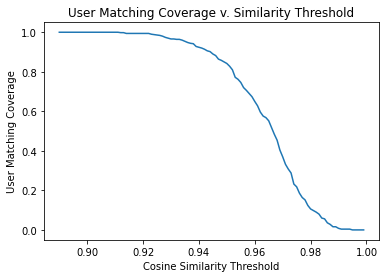

In [ ]:
coverages = []
for i in np.arange(0.89, 1, 0.001):
  coverages.append(UserCoverage(sample_similarities_1, 500, i))
plt.plot(np.arange(0.89, 1, 0.001), coverages)
plt.title('User Matching Coverage v. Similarity Threshold')
plt.xlabel('Cosine Similarity Threshold')
plt.ylabel('User Matching Coverage')

In [ ]:
for tuple in zip(np.arange(0.89, 1, 0.001), coverages):
  print(tuple)


(0.89, 1.0)
(0.891, 1.0)
(0.892, 1.0)
(0.893, 1.0)
(0.894, 1.0)
(0.895, 1.0)
(0.896, 1.0)
(0.897, 1.0)
(0.898, 1.0)
(0.899, 1.0)
(0.9, 1.0)
(0.901, 1.0)
(0.902, 1.0)
(0.903, 1.0)
(0.904, 1.0)
(0.905, 1.0)
(0.906, 1.0)
(0.907, 1.0)
(0.908, 1.0)
(0.909, 1.0)
(0.91, 1.0)
(0.911, 1.0)
(0.912, 0.998)
(0.913, 0.998)
(0.914, 0.994)
(0.915, 0.994)
(0.916, 0.994)
(0.917, 0.994)
(0.918, 0.994)
(0.919, 0.994)
(0.92, 0.994)
(0.921, 0.994)
(0.922, 0.994)
(0.923, 0.99)
(0.924, 0.988)
(0.925, 0.986)
(0.926, 0.984)
(0.927, 0.98)
(0.928, 0.974)
(0.929, 0.97)
(0.93, 0.966)
(0.931, 0.966)
(0.932, 0.964)
(0.933, 0.964)
(0.934, 0.96)
(0.935, 0.954)
(0.936, 0.948)
(0.937, 0.944)
(0.9380000000000001, 0.942)
(0.9390000000000001, 0.928)
(0.9400000000000001, 0.924)
(0.9410000000000001, 0.92)
(0.9420000000000001, 0.914)
(0.9430000000000001, 0.906)
(0.9440000000000001, 0.902)
(0.9450000000000001, 0.89)
(0.9460000000000001, 0.882)
(0.9470000000000001, 0.864)
(0.9480000000000001, 0.858)
(0.9490000000000001, 0.85)
(

In [ ]:
import itertools

def Diversity(topNPredicted, user_to_emb):
  print("RUNNING DIVERSITY")
  n = 0
  total = 0
  key_count = 0
  for userID in topNPredicted.keys():
    if key_count % 20 == 0:
      print(key_count)
    key_count += 1
    pairs = itertools.combinations(topNPredicted[userID], 2)
    for pair in pairs:
      # print(pair)
      user_1 = pair[0]
      user_2 = pair[1]
      similarity = cosine_similarity(user_to_emb[user_1].reshape(1,-1), user_to_emb[user_2].reshape(1, -1))[0][0]
      total += similarity
      n += 1
  S = total / n
  return (1-S)

In [ ]:
Diversity(sample_similarities_1, user_embeds)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


0.12081407163736146

RUNNING SAMPLE SIMILARITIES FOR 10 USERS
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING DIVERSITY
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING SAMPLE SIMILARITIES FOR 20 USERS
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING DIVERSITY
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING SAMPLE SIMILARITIES FOR 30 USERS
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING DIVERSITY
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING SAMPLE SIMILARITIES FOR 40 USERS
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING DIVERSITY
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
RUNNING SAMP

Text(0, 0.5, 'User Matching Diversity')

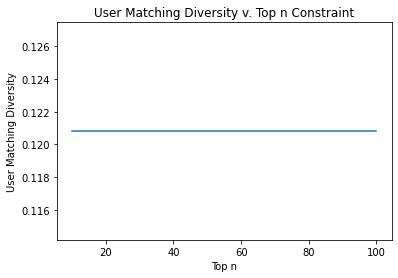

In [ ]:
divs = []

for i in range(10, 101, 10):
  sample_similarities = get_similarities(get_random_users(users, 500), user_embeds, i)
  div = Diversity(sample_similarities_1, user_embeds)
  divs.append(div)

plt.plot(range(10, 101, 10), divs)
plt.title('User Matching Diversity v. Top n Constraint')
plt.xlabel('Top n')
plt.ylabel('User Matching Diversity')

In [ ]:
divs

[0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146,
 0.12081407163736146]

In [ ]:
import csv

sample_similarities = get_similarities(get_random_users(users, 100), user_embeds, 10)

nodes = []
edges = []
all_edges = []
strong_edges = []

for user1 in sample_similarities:
  for user2 in sample_similarities[user1]:
    if user1 not in nodes:
      nodes.append([user1])
    if user2 not in nodes:
      nodes.append([user2])
    all_edges.append((user1, user2))
    if (user1, user2) not in edges and (user2, user1) not in edges:
      edges.append((user1, user2))

for user1 in sample_similarities:
  for user2 in sample_similarities[user1]:
    if (user1, user2) in all_edges and (user2, user1) in all_edges:
      strong_edges.append((user1, user2))

print(len(edges))
print(len(strong_edges))

RUNNING SAMPLE SIMILARITIES FOR 10 USERS
0
20
40
60
80
675
650


In [ ]:
with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/strong_edges.csv', 'w') as csvfile:
    fieldnames = ['node_0_id', 'node_1_id']
    writer = csv.writer(csvfile)

    # writer.writerow({'node_0_id': edges_0, 'node_1_id': edges_1})
    # writer.writerow(['Node 1', 'Node 2'])

    for edge in strong_edges:
      # print(edge)
      writer.writerow([edge[0], edge[1]])

csvfile.close()

with open('/content/drive/My Drive/DVA Team Kobe/yelp-dataset/nodes.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
    
    write.writerow(['node_id'])
    write.writerows(nodes)

In [ ]:
graph_info = {"rawGraph":{"nodes":[{"id":"BZO7J9clpV60MA3hFhYMdg","degree":14,"pagerank":0.0020985400063812123,"node_id":"BZO7J9clpV60MA3hFhYMdg","isHidden":false},{"id":"ZpSZiNAmw-IqDLlvqsK1Rg","degree":11,"pagerank":0.0018059482997388942,"node_id":"ZpSZiNAmw-IqDLlvqsK1Rg","isHidden":false},{"id":"2qeSKvqlYobFcyCAWTUz6Q","degree":22,"pagerank":0.013516745572313428,"node_id":"2qeSKvqlYobFcyCAWTUz6Q","isHidden":false},{"id":"h51yI4p8ktLnKsn_nLR4cw","degree":28,"pagerank":0.12205881494259199,"node_id":"h51yI4p8ktLnKsn_nLR4cw","isHidden":false},{"id":"_wivO-J9xBmHAiMGAmzanQ","degree":13,"pagerank":0.003964497189588497,"node_id":"_wivO-J9xBmHAiMGAmzanQ","isHidden":false},{"id":"zMWuzd5ltG0MAfYwxpN02w","degree":13,"pagerank":0.004050770216813154,"node_id":"zMWuzd5ltG0MAfYwxpN02w","isHidden":false},{"id":"AhgpOJo0ym5yzjvlYWQSKQ","degree":13,"pagerank":0.002880489592944538,"node_id":"AhgpOJo0ym5yzjvlYWQSKQ","isHidden":false},{"id":"H-gllDEH0DHqE-HmzdHtKg","degree":14,"pagerank":0.007696191909715423,"node_id":"H-gllDEH0DHqE-HmzdHtKg","isHidden":false},{"id":"LlgpGAojPcbaKcMBLFYnoQ","degree":25,"pagerank":0.016156661273568046,"node_id":"LlgpGAojPcbaKcMBLFYnoQ","isHidden":false},{"id":"vwRG7r8kELEqN60ep_JgEg","degree":15,"pagerank":0.005952818237539437,"node_id":"vwRG7r8kELEqN60ep_JgEg","isHidden":false},{"id":"Doz1cAtxFL_1yY0BK7VZKg","degree":34,"pagerank":0.031336741060519376,"node_id":"Doz1cAtxFL_1yY0BK7VZKg","isHidden":false},{"id":"33oFUKJxEY0ibryhb6WTSA","degree":11,"pagerank":0.007792809529274744,"node_id":"33oFUKJxEY0ibryhb6WTSA","isHidden":false},{"id":"-jHpOIReEQXYymg3duqqqg","degree":14,"pagerank":0.004697652489308871,"node_id":"-jHpOIReEQXYymg3duqqqg","isHidden":false},{"id":"rb6vMqFYgNvWduP5iMxsPA","degree":24,"pagerank":0.023685093160237796,"node_id":"rb6vMqFYgNvWduP5iMxsPA","isHidden":false},{"id":"H9MpjeuPqSOqkE_cAR2WZQ","degree":16,"pagerank":0.0038020236270993077,"node_id":"H9MpjeuPqSOqkE_cAR2WZQ","isHidden":false},{"id":"H2FahZmg6BKHOFaLnUXgsQ","degree":20,"pagerank":0.021836453369879175,"node_id":"H2FahZmg6BKHOFaLnUXgsQ","isHidden":false},{"id":"2cLb3vlMpheQYMPUEDrcJg","degree":13,"pagerank":0.002573798996704794,"node_id":"2cLb3vlMpheQYMPUEDrcJg","isHidden":false},{"id":"hCj59G02wcetopvJOPJyXQ","degree":13,"pagerank":0.006974928886623532,"node_id":"hCj59G02wcetopvJOPJyXQ","isHidden":false},{"id":"C_k7E01kEUAmjj3oQrKtBQ","degree":18,"pagerank":0.024412795809164903,"node_id":"C_k7E01kEUAmjj3oQrKtBQ","isHidden":false},{"id":"AhDMNMpXBaJMOULaHfKHjA","degree":18,"pagerank":0.007275892486063793,"node_id":"AhDMNMpXBaJMOULaHfKHjA","isHidden":false},{"id":"z3n4lF8oWYahp-3Hx56d7A","degree":11,"pagerank":0.0022371773795954067,"node_id":"z3n4lF8oWYahp-3Hx56d7A","isHidden":false},{"id":"adKonsQWY64vJYglPotH5Q","degree":13,"pagerank":0.004749239235085117,"node_id":"adKonsQWY64vJYglPotH5Q","isHidden":false},{"id":"btFpKUsEr752UkokGj1nXg","degree":12,"pagerank":0.0017869985479849635,"node_id":"btFpKUsEr752UkokGj1nXg","isHidden":false},{"id":"LOhPtNsOYUqYQlTL5t9TQQ","degree":12,"pagerank":0.004001287572803117,"node_id":"LOhPtNsOYUqYQlTL5t9TQQ","isHidden":false},{"id":"RGBCzJRMDaQ8kd772VAgXA","degree":18,"pagerank":0.005106910022154248,"node_id":"RGBCzJRMDaQ8kd772VAgXA","isHidden":false},{"id":"FnvkegjU7zy5lFkG0qnPbQ","degree":11,"pagerank":0.0019993762064991986,"node_id":"FnvkegjU7zy5lFkG0qnPbQ","isHidden":false},{"id":"zdm7AKL5v4IK2b6vFX_zbw","degree":16,"pagerank":0.00811225972580187,"node_id":"zdm7AKL5v4IK2b6vFX_zbw","isHidden":false},{"id":"auawU27a7QahsJntjWB-rQ","degree":36,"pagerank":0.02881193816779038,"node_id":"auawU27a7QahsJntjWB-rQ","isHidden":false},{"id":"pNyeQrZo2x6u7FLriu-ifQ","degree":17,"pagerank":0.009288106027941345,"node_id":"pNyeQrZo2x6u7FLriu-ifQ","isHidden":false},{"id":"awR2rcayaSxYLnMNbtfTwQ","degree":12,"pagerank":0.0018300702313136903,"node_id":"awR2rcayaSxYLnMNbtfTwQ","isHidden":false},{"id":"-znd1838pT6ROqlCuZASgg","degree":11,"pagerank":0.007808423093019141,"node_id":"-znd1838pT6ROqlCuZASgg","isHidden":false},{"id":"oZzie8w_J9kZy6e7f-MAUg","degree":14,"pagerank":0.0029913210301845262,"node_id":"oZzie8w_J9kZy6e7f-MAUg","isHidden":false},{"id":"UlQb5tOcoigkYKFkZ7xehg","degree":11,"pagerank":0.005061862223735216,"node_id":"UlQb5tOcoigkYKFkZ7xehg","isHidden":false},{"id":"92A1z-J4XnG413TDpGYZ4A","degree":13,"pagerank":0.004930896637826072,"node_id":"92A1z-J4XnG413TDpGYZ4A","isHidden":false},{"id":"hy6vDb3z63rTN4ksffO7WA","degree":34,"pagerank":0.06092603121230986,"node_id":"hy6vDb3z63rTN4ksffO7WA","isHidden":false},{"id":"rwDCh__F6Y-x9_RLAFgaaA","degree":10,"pagerank":0.0038365868941284027,"node_id":"rwDCh__F6Y-x9_RLAFgaaA","isHidden":false},{"id":"RUxEeMPFScLbFN0TdSyInA","degree":14,"pagerank":0.00949578804477221,"node_id":"RUxEeMPFScLbFN0TdSyInA","isHidden":false},{"id":"DBrqEIFkJ5Va5kHhBtsiog","degree":16,"pagerank":0.012084802886218016,"node_id":"DBrqEIFkJ5Va5kHhBtsiog","isHidden":false},{"id":"LnwX0vvjXUH3etbO6_1vYw","degree":10,"pagerank":0.0015000000000000013,"node_id":"LnwX0vvjXUH3etbO6_1vYw","isHidden":false},{"id":"FYiHUYRSGn7gciEC7JndXw","degree":11,"pagerank":0.007032782746492511,"node_id":"FYiHUYRSGn7gciEC7JndXw","isHidden":false},{"id":"egYpToYUMXVj7Z7Cy5kKdg","degree":12,"pagerank":0.00656139525146315,"node_id":"egYpToYUMXVj7Z7Cy5kKdg","isHidden":false},{"id":"R3A0rNRF3taVIPrrqba3Ig","degree":13,"pagerank":0.004360044783432818,"node_id":"R3A0rNRF3taVIPrrqba3Ig","isHidden":false},{"id":"uOwQ2NEQfNVaUVFyAW2Q_g","degree":24,"pagerank":0.0728645438879298,"node_id":"uOwQ2NEQfNVaUVFyAW2Q_g","isHidden":false},{"id":"LpZAjpQWyv2BuOHvvGelcg","degree":11,"pagerank":0.003601726560304781,"node_id":"LpZAjpQWyv2BuOHvvGelcg","isHidden":false},{"id":"OXeDFesQZYjiO6b0E7ukuA","degree":11,"pagerank":0.007701500432754318,"node_id":"OXeDFesQZYjiO6b0E7ukuA","isHidden":false},{"id":"MTuJD943phkx-DTcth_Lng","degree":12,"pagerank":0.004896265341229845,"node_id":"MTuJD943phkx-DTcth_Lng","isHidden":false},{"id":"psl7HjiM0dSVfD9UbNNILw","degree":12,"pagerank":0.0045273045787843705,"node_id":"psl7HjiM0dSVfD9UbNNILw","isHidden":false},{"id":"8StTNe4RLRqyaGW0pG38bw","degree":10,"pagerank":0.0037463744599736514,"node_id":"8StTNe4RLRqyaGW0pG38bw","isHidden":false},{"id":"skh8lAOi2eBlX7LXlBvGAQ","degree":16,"pagerank":0.11579171882714416,"node_id":"skh8lAOi2eBlX7LXlBvGAQ","isHidden":false},{"id":"JMw9SfB-5KJqAeaOnJzlsA","degree":12,"pagerank":0.0022057569699276704,"node_id":"JMw9SfB-5KJqAeaOnJzlsA","isHidden":false},{"id":"lb_MoZ4HbOeWF5ijSo1LkQ","degree":14,"pagerank":0.006365969231500742,"node_id":"lb_MoZ4HbOeWF5ijSo1LkQ","isHidden":false},{"id":"ezfvGnhpSHqkN0J5Kdi_cA","degree":10,"pagerank":0.0016879731283300677,"node_id":"ezfvGnhpSHqkN0J5Kdi_cA","isHidden":false},{"id":"nqCkbI7L6JsnPOV3irmX6Q","degree":13,"pagerank":0.006475614245237968,"node_id":"nqCkbI7L6JsnPOV3irmX6Q","isHidden":false},{"id":"Fuhl9J5Y-UMeEir0cI-Ajg","degree":14,"pagerank":0.0064183007619277735,"node_id":"Fuhl9J5Y-UMeEir0cI-Ajg","isHidden":false},{"id":"DWcqseFen5lCCk33qQ0vqA","degree":11,"pagerank":0.0016275000000000011,"node_id":"DWcqseFen5lCCk33qQ0vqA","isHidden":false},{"id":"V1Xc1ButJ0DoRpWE0eCGtw","degree":11,"pagerank":0.0022787781586207576,"node_id":"V1Xc1ButJ0DoRpWE0eCGtw","isHidden":false},{"id":"f27F-r2y8Nq5iOazJ_zJHw","degree":10,"pagerank":0.0018972136881575316,"node_id":"f27F-r2y8Nq5iOazJ_zJHw","isHidden":false},{"id":"WaACjdTwOtAEptj24p5WJw","degree":10,"pagerank":0.002196129186596889,"node_id":"WaACjdTwOtAEptj24p5WJw","isHidden":false},{"id":"_V0n0j-QmC1iIFQlRv_FLg","degree":13,"pagerank":0.012115625879573958,"node_id":"_V0n0j-QmC1iIFQlRv_FLg","isHidden":false},{"id":"M6NGWADdQ-4BMBiVrrcunw","degree":14,"pagerank":0.0027384961913993525,"node_id":"M6NGWADdQ-4BMBiVrrcunw","isHidden":false},{"id":"VXkbpAK5mwq1jIvCO4eKpQ","degree":14,"pagerank":0.004166472810741159,"node_id":"VXkbpAK5mwq1jIvCO4eKpQ","isHidden":false},{"id":"kX0HjXFaGuA2ysszxn8ibg","degree":18,"pagerank":0.005818369267405931,"node_id":"kX0HjXFaGuA2ysszxn8ibg","isHidden":false},{"id":"4AFjYLrQN3mDf7KBiR21MA","degree":20,"pagerank":0.010128104009877953,"node_id":"4AFjYLrQN3mDf7KBiR21MA","isHidden":false},{"id":"oxHhTVfDgyEY8L0VgRPejg","degree":11,"pagerank":0.016300725265056736,"node_id":"oxHhTVfDgyEY8L0VgRPejg","isHidden":false},{"id":"zRbCf0-03uYns4dDgrkecw","degree":11,"pagerank":0.002151775102738302,"node_id":"zRbCf0-03uYns4dDgrkecw","isHidden":false},{"id":"1NUYhZpoTw_qTAScubDCzQ","degree":10,"pagerank":0.0030698036927405076,"node_id":"1NUYhZpoTw_qTAScubDCzQ","isHidden":false},{"id":"vUTznjOaVlz0UriWu_Qr4w","degree":10,"pagerank":0.0037114620057966522,"node_id":"vUTznjOaVlz0UriWu_Qr4w","isHidden":false},{"id":"KVpxv4P6Dyu6nz86VwnAig","degree":12,"pagerank":0.0025090561271064425,"node_id":"KVpxv4P6Dyu6nz86VwnAig","isHidden":false},{"id":"18AxcS_2rcbmQHcucX8kYw","degree":10,"pagerank":0.0030080837745818157,"node_id":"18AxcS_2rcbmQHcucX8kYw","isHidden":false},{"id":"StC50D4iRw5CZfB1RkGxcg","degree":15,"pagerank":0.01526635015443848,"node_id":"StC50D4iRw5CZfB1RkGxcg","isHidden":false},{"id":"wSLhA44wZrVeeYzCQdVy0A","degree":10,"pagerank":0.0017368615250748104,"node_id":"wSLhA44wZrVeeYzCQdVy0A","isHidden":false},{"id":"3YlDyqYIsu8FyrnTMNacBw","degree":18,"pagerank":0.009121407398940119,"node_id":"3YlDyqYIsu8FyrnTMNacBw","isHidden":false},{"id":"1C6EuYoU8A3-xCbGGg-w8Q","degree":11,"pagerank":0.006909200528583874,"node_id":"1C6EuYoU8A3-xCbGGg-w8Q","isHidden":false},{"id":"t-YnW3lLnkauyS4z1J2KLQ","degree":14,"pagerank":0.0025923596925251707,"node_id":"t-YnW3lLnkauyS4z1J2KLQ","isHidden":false},{"id":"Lpm5II5f5XI1VI6uZL37cA","degree":11,"pagerank":0.0036057567621024847,"node_id":"Lpm5II5f5XI1VI6uZL37cA","isHidden":false},{"id":"Cv2z6aruu8b_clrxnhD2WQ","degree":11,"pagerank":0.0026814517414500364,"node_id":"Cv2z6aruu8b_clrxnhD2WQ","isHidden":false},{"id":"jOUpQ78DBGUWwOCjjXpSrQ","degree":10,"pagerank":0.008159513794117557,"node_id":"jOUpQ78DBGUWwOCjjXpSrQ","isHidden":false},{"id":"Lfjme7LTjbwugDGJLLpg0w","degree":10,"pagerank":0.003971575033919534,"node_id":"Lfjme7LTjbwugDGJLLpg0w","isHidden":false},{"id":"srou4DkAZLbVsgAPGqzN-g","degree":22,"pagerank":0.05028525556158637,"node_id":"srou4DkAZLbVsgAPGqzN-g","isHidden":false},{"id":"22tpme9flBIeXRvXAeJ3yw","degree":10,"pagerank":0.0024853045071733843,"node_id":"22tpme9flBIeXRvXAeJ3yw","isHidden":false},{"id":"qYhPjTGtXE3DUJBahe85aQ","degree":10,"pagerank":0.0015000000000000013,"node_id":"qYhPjTGtXE3DUJBahe85aQ","isHidden":false},{"id":"r2moK4vDs9mNlHPqyUGVOg","degree":10,"pagerank":0.0022296260140348178,"node_id":"r2moK4vDs9mNlHPqyUGVOg","isHidden":false},{"id":"ltYYnHmh6KoqqROiPkTv8g","degree":10,"pagerank":0.001807357434638075,"node_id":"ltYYnHmh6KoqqROiPkTv8g","isHidden":false},{"id":"-eQ1LfRLvS2iEwy2vmRJlQ","degree":12,"pagerank":0.002117666126006691,"node_id":"-eQ1LfRLvS2iEwy2vmRJlQ","isHidden":false},{"id":"P4AxBC_5533A7CzkrFgsnw","degree":12,"pagerank":0.005998784650764339,"node_id":"P4AxBC_5533A7CzkrFgsnw","isHidden":false},{"id":"y9cyIC5VbyQ58WDLGbeDag","degree":11,"pagerank":0.004331733058139336,"node_id":"y9cyIC5VbyQ58WDLGbeDag","isHidden":false},{"id":"5WyMH7TvmtMBLo7Is3HeuA","degree":10,"pagerank":0.003548017006296828,"node_id":"5WyMH7TvmtMBLo7Is3HeuA","isHidden":false},{"id":"-XS0hiiOrWyH_MJDBsq41Q","degree":10,"pagerank":0.0015000000000000013,"node_id":"-XS0hiiOrWyH_MJDBsq41Q","isHidden":false},{"id":"oPSGprSyisgm-G_GgmnvoQ","degree":11,"pagerank":0.006972342811550787,"node_id":"oPSGprSyisgm-G_GgmnvoQ","isHidden":false},{"id":"iHpe1GW15oq07_ybHrftlw","degree":10,"pagerank":0.004267821365573344,"node_id":"iHpe1GW15oq07_ybHrftlw","isHidden":false},{"id":"E6C-y4TjrnQOuBmep2Lvig","degree":10,"pagerank":0.0023391768984881065,"node_id":"E6C-y4TjrnQOuBmep2Lvig","isHidden":false},{"id":"CRSPg66k0UyuJherIkbpaw","degree":16,"pagerank":0.01384874374478644,"node_id":"CRSPg66k0UyuJherIkbpaw","isHidden":false},{"id":"Lk6PqOP7qaSmSZKtHmGUjw","degree":11,"pagerank":0.013012586027748158,"node_id":"Lk6PqOP7qaSmSZKtHmGUjw","isHidden":false},{"id":"7LQBGWwC_-BIZoPTIkuaOw","degree":10,"pagerank":0.0015000000000000013,"node_id":"7LQBGWwC_-BIZoPTIkuaOw","isHidden":false},{"id":"_g2Ot_WYmP9stOorUK9MaQ","degree":10,"pagerank":0.0015000000000000013,"node_id":"_g2Ot_WYmP9stOorUK9MaQ","isHidden":false},{"id":"k_75r5XZBLefbQJrLfyuXw","degree":10,"pagerank":0.0015000000000000013,"node_id":"k_75r5XZBLefbQJrLfyuXw","isHidden":false},{"id":"-UdA9RKqNvJDGTNGY4JI_A","degree":10,"pagerank":0.0015000000000000013,"node_id":"-UdA9RKqNvJDGTNGY4JI_A","isHidden":false},{"id":"RCnr2vvpBpaF0XTJTKNsDA","degree":11,"pagerank":0.0016275000000000011,"node_id":"RCnr2vvpBpaF0XTJTKNsDA","isHidden":false},{"id":"wrE5F2UXp63DZKZce4NQbw","degree":10,"pagerank":0.0015000000000000013,"node_id":"wrE5F2UXp63DZKZce4NQbw","isHidden":false},{"id":"LXJsmzMH44lw_c3VpFb5nQ","degree":10,"pagerank":0.0015000000000000013,"node_id":"LXJsmzMH44lw_c3VpFb5nQ","isHidden":false}],"edges":[{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"ZpSZiNAmw-IqDLlvqsK1Rg"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"_wivO-J9xBmHAiMGAmzanQ"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"BZO7J9clpV60MA3hFhYMdg","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"_wivO-J9xBmHAiMGAmzanQ"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"2qeSKvqlYobFcyCAWTUz6Q","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"2cLb3vlMpheQYMPUEDrcJg"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"_wivO-J9xBmHAiMGAmzanQ"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"z3n4lF8oWYahp-3Hx56d7A"},{"source_id":"H9MpjeuPqSOqkE_cAR2WZQ","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"LOhPtNsOYUqYQlTL5t9TQQ"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"FnvkegjU7zy5lFkG0qnPbQ"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"btFpKUsEr752UkokGj1nXg","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"-znd1838pT6ROqlCuZASgg"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"oZzie8w_J9kZy6e7f-MAUg"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"BZO7J9clpV60MA3hFhYMdg"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"rwDCh__F6Y-x9_RLAFgaaA"},{"source_id":"awR2rcayaSxYLnMNbtfTwQ","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"_wivO-J9xBmHAiMGAmzanQ","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"FYiHUYRSGn7gciEC7JndXw"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"egYpToYUMXVj7Z7Cy5kKdg"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"LpZAjpQWyv2BuOHvvGelcg"},{"source_id":"LnwX0vvjXUH3etbO6_1vYw","target_id":"OXeDFesQZYjiO6b0E7ukuA"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"awR2rcayaSxYLnMNbtfTwQ"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"-znd1838pT6ROqlCuZASgg"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"MTuJD943phkx-DTcth_Lng"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"oZzie8w_J9kZy6e7f-MAUg"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"ZpSZiNAmw-IqDLlvqsK1Rg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"OXeDFesQZYjiO6b0E7ukuA"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"8StTNe4RLRqyaGW0pG38bw"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"rb6vMqFYgNvWduP5iMxsPA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"FnvkegjU7zy5lFkG0qnPbQ"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"lb_MoZ4HbOeWF5ijSo1LkQ"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"ezfvGnhpSHqkN0J5Kdi_cA"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"BZO7J9clpV60MA3hFhYMdg"},{"source_id":"JMw9SfB-5KJqAeaOnJzlsA","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"V1Xc1ButJ0DoRpWE0eCGtw"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"f27F-r2y8Nq5iOazJ_zJHw"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"WaACjdTwOtAEptj24p5WJw"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"M6NGWADdQ-4BMBiVrrcunw"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"DWcqseFen5lCCk33qQ0vqA","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"FYiHUYRSGn7gciEC7JndXw"},{"source_id":"AhDMNMpXBaJMOULaHfKHjA","target_id":"OXeDFesQZYjiO6b0E7ukuA"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"1NUYhZpoTw_qTAScubDCzQ"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"egYpToYUMXVj7Z7Cy5kKdg"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"vUTznjOaVlz0UriWu_Qr4w"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"KVpxv4P6Dyu6nz86VwnAig"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"zRbCf0-03uYns4dDgrkecw","target_id":"18AxcS_2rcbmQHcucX8kYw"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"wSLhA44wZrVeeYzCQdVy0A"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"KVpxv4P6Dyu6nz86VwnAig","target_id":"1C6EuYoU8A3-xCbGGg-w8Q"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"Lpm5II5f5XI1VI6uZL37cA"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"oZzie8w_J9kZy6e7f-MAUg"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"2cLb3vlMpheQYMPUEDrcJg"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"JMw9SfB-5KJqAeaOnJzlsA"},{"source_id":"t-YnW3lLnkauyS4z1J2KLQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"jOUpQ78DBGUWwOCjjXpSrQ"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"WaACjdTwOtAEptj24p5WJw"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"Lfjme7LTjbwugDGJLLpg0w"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"Cv2z6aruu8b_clrxnhD2WQ","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"f27F-r2y8Nq5iOazJ_zJHw"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"M6NGWADdQ-4BMBiVrrcunw","target_id":"22tpme9flBIeXRvXAeJ3yw"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"Doz1cAtxFL_1yY0BK7VZKg","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"r2moK4vDs9mNlHPqyUGVOg"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"ltYYnHmh6KoqqROiPkTv8g"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"btFpKUsEr752UkokGj1nXg"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"lb_MoZ4HbOeWF5ijSo1LkQ"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"qYhPjTGtXE3DUJBahe85aQ","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"1NUYhZpoTw_qTAScubDCzQ"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"LpZAjpQWyv2BuOHvvGelcg"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"rwDCh__F6Y-x9_RLAFgaaA"},{"source_id":"egYpToYUMXVj7Z7Cy5kKdg","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"ltYYnHmh6KoqqROiPkTv8g"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"MTuJD943phkx-DTcth_Lng"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"-eQ1LfRLvS2iEwy2vmRJlQ","target_id":"y9cyIC5VbyQ58WDLGbeDag"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"-znd1838pT6ROqlCuZASgg"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"Lpm5II5f5XI1VI6uZL37cA"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"oZzie8w_J9kZy6e7f-MAUg","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"V1Xc1ButJ0DoRpWE0eCGtw"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"WaACjdTwOtAEptj24p5WJw"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"5WyMH7TvmtMBLo7Is3HeuA"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"LOhPtNsOYUqYQlTL5t9TQQ"},{"source_id":"f27F-r2y8Nq5iOazJ_zJHw","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"z3n4lF8oWYahp-3Hx56d7A"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"WaACjdTwOtAEptj24p5WJw"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"V1Xc1ButJ0DoRpWE0eCGtw"},{"source_id":"-XS0hiiOrWyH_MJDBsq41Q","target_id":"oPSGprSyisgm-G_GgmnvoQ"},{"source_id":"WaACjdTwOtAEptj24p5WJw","target_id":"V1Xc1ButJ0DoRpWE0eCGtw"},{"source_id":"WaACjdTwOtAEptj24p5WJw","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"WaACjdTwOtAEptj24p5WJw","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"WaACjdTwOtAEptj24p5WJw","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"WaACjdTwOtAEptj24p5WJw","target_id":"LpZAjpQWyv2BuOHvvGelcg"},{"source_id":"WaACjdTwOtAEptj24p5WJw","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"-eQ1LfRLvS2iEwy2vmRJlQ"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"iHpe1GW15oq07_ybHrftlw"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"FYiHUYRSGn7gciEC7JndXw"},{"source_id":"wSLhA44wZrVeeYzCQdVy0A","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"OXeDFesQZYjiO6b0E7ukuA"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"LpZAjpQWyv2BuOHvvGelcg"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"1C6EuYoU8A3-xCbGGg-w8Q"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"8StTNe4RLRqyaGW0pG38bw","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"MTuJD943phkx-DTcth_Lng"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"3YlDyqYIsu8FyrnTMNacBw","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"FnvkegjU7zy5lFkG0qnPbQ","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"LOhPtNsOYUqYQlTL5t9TQQ"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"22tpme9flBIeXRvXAeJ3yw"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"btFpKUsEr752UkokGj1nXg"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"FnvkegjU7zy5lFkG0qnPbQ"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"awR2rcayaSxYLnMNbtfTwQ"},{"source_id":"ezfvGnhpSHqkN0J5Kdi_cA","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"M6NGWADdQ-4BMBiVrrcunw"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"18AxcS_2rcbmQHcucX8kYw"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"V1Xc1ButJ0DoRpWE0eCGtw","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"AhgpOJo0ym5yzjvlYWQSKQ","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"AhgpOJo0ym5yzjvlYWQSKQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"AhgpOJo0ym5yzjvlYWQSKQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"AhgpOJo0ym5yzjvlYWQSKQ","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"AhgpOJo0ym5yzjvlYWQSKQ","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"4AFjYLrQN3mDf7KBiR21MA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"4AFjYLrQN3mDf7KBiR21MA","target_id":"1C6EuYoU8A3-xCbGGg-w8Q"},{"source_id":"4AFjYLrQN3mDf7KBiR21MA","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"4AFjYLrQN3mDf7KBiR21MA","target_id":"Lpm5II5f5XI1VI6uZL37cA"},{"source_id":"4AFjYLrQN3mDf7KBiR21MA","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"4AFjYLrQN3mDf7KBiR21MA","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"r2moK4vDs9mNlHPqyUGVOg"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"E6C-y4TjrnQOuBmep2Lvig"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"lb_MoZ4HbOeWF5ijSo1LkQ","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"E6C-y4TjrnQOuBmep2Lvig"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"Lk6PqOP7qaSmSZKtHmGUjw"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"2cLb3vlMpheQYMPUEDrcJg"},{"source_id":"r2moK4vDs9mNlHPqyUGVOg","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"LOhPtNsOYUqYQlTL5t9TQQ"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"FYiHUYRSGn7gciEC7JndXw"},{"source_id":"kX0HjXFaGuA2ysszxn8ibg","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"Fuhl9J5Y-UMeEir0cI-Ajg","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"-znd1838pT6ROqlCuZASgg"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"RGBCzJRMDaQ8kd772VAgXA","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"H-gllDEH0DHqE-HmzdHtKg","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"H-gllDEH0DHqE-HmzdHtKg","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"H-gllDEH0DHqE-HmzdHtKg","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"H-gllDEH0DHqE-HmzdHtKg","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"H-gllDEH0DHqE-HmzdHtKg","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"H-gllDEH0DHqE-HmzdHtKg","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"18AxcS_2rcbmQHcucX8kYw"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"22tpme9flBIeXRvXAeJ3yw"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"t-YnW3lLnkauyS4z1J2KLQ"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"2cLb3vlMpheQYMPUEDrcJg"},{"source_id":"7LQBGWwC_-BIZoPTIkuaOw","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"-jHpOIReEQXYymg3duqqqg","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"Lk6PqOP7qaSmSZKtHmGUjw"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"hy6vDb3z63rTN4ksffO7WA","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"RUxEeMPFScLbFN0TdSyInA","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"RUxEeMPFScLbFN0TdSyInA","target_id":"vUTznjOaVlz0UriWu_Qr4w"},{"source_id":"RUxEeMPFScLbFN0TdSyInA","target_id":"1C6EuYoU8A3-xCbGGg-w8Q"},{"source_id":"RUxEeMPFScLbFN0TdSyInA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"h51yI4p8ktLnKsn_nLR4cw","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"auawU27a7QahsJntjWB-rQ","target_id":"-znd1838pT6ROqlCuZASgg"},{"source_id":"auawU27a7QahsJntjWB-rQ","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"auawU27a7QahsJntjWB-rQ","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"auawU27a7QahsJntjWB-rQ","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"auawU27a7QahsJntjWB-rQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"VXkbpAK5mwq1jIvCO4eKpQ","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"vwRG7r8kELEqN60ep_JgEg","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"vwRG7r8kELEqN60ep_JgEg","target_id":"y9cyIC5VbyQ58WDLGbeDag"},{"source_id":"vwRG7r8kELEqN60ep_JgEg","target_id":"LOhPtNsOYUqYQlTL5t9TQQ"},{"source_id":"vwRG7r8kELEqN60ep_JgEg","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"vwRG7r8kELEqN60ep_JgEg","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"LlgpGAojPcbaKcMBLFYnoQ","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"LlgpGAojPcbaKcMBLFYnoQ","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"LlgpGAojPcbaKcMBLFYnoQ","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"LlgpGAojPcbaKcMBLFYnoQ","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"LlgpGAojPcbaKcMBLFYnoQ","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"LlgpGAojPcbaKcMBLFYnoQ","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"BZO7J9clpV60MA3hFhYMdg"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"_g2Ot_WYmP9stOorUK9MaQ","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"_wivO-J9xBmHAiMGAmzanQ"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"33oFUKJxEY0ibryhb6WTSA"},{"source_id":"z3n4lF8oWYahp-3Hx56d7A","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"33oFUKJxEY0ibryhb6WTSA","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"33oFUKJxEY0ibryhb6WTSA","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"33oFUKJxEY0ibryhb6WTSA","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"33oFUKJxEY0ibryhb6WTSA","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"MTuJD943phkx-DTcth_Lng"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"2cLb3vlMpheQYMPUEDrcJg"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"-znd1838pT6ROqlCuZASgg"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"ZpSZiNAmw-IqDLlvqsK1Rg"},{"source_id":"k_75r5XZBLefbQJrLfyuXw","target_id":"oZzie8w_J9kZy6e7f-MAUg"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"Lfjme7LTjbwugDGJLLpg0w"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"vUTznjOaVlz0UriWu_Qr4w","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"FYiHUYRSGn7gciEC7JndXw"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"y9cyIC5VbyQ58WDLGbeDag"},{"source_id":"pNyeQrZo2x6u7FLriu-ifQ","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"22tpme9flBIeXRvXAeJ3yw"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"Lpm5II5f5XI1VI6uZL37cA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"y9cyIC5VbyQ58WDLGbeDag"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"RCnr2vvpBpaF0XTJTKNsDA"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"oPSGprSyisgm-G_GgmnvoQ"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"-UdA9RKqNvJDGTNGY4JI_A","target_id":"M6NGWADdQ-4BMBiVrrcunw"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"2cLb3vlMpheQYMPUEDrcJg","target_id":"_wivO-J9xBmHAiMGAmzanQ"},{"source_id":"-znd1838pT6ROqlCuZASgg","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"-znd1838pT6ROqlCuZASgg","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"-znd1838pT6ROqlCuZASgg","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"-znd1838pT6ROqlCuZASgg","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"-znd1838pT6ROqlCuZASgg","target_id":"MTuJD943phkx-DTcth_Lng"},{"source_id":"zdm7AKL5v4IK2b6vFX_zbw","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"zdm7AKL5v4IK2b6vFX_zbw","target_id":"jOUpQ78DBGUWwOCjjXpSrQ"},{"source_id":"zdm7AKL5v4IK2b6vFX_zbw","target_id":"OXeDFesQZYjiO6b0E7ukuA"},{"source_id":"zdm7AKL5v4IK2b6vFX_zbw","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"zdm7AKL5v4IK2b6vFX_zbw","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"LOhPtNsOYUqYQlTL5t9TQQ","target_id":"M6NGWADdQ-4BMBiVrrcunw"},{"source_id":"LOhPtNsOYUqYQlTL5t9TQQ","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"LOhPtNsOYUqYQlTL5t9TQQ","target_id":"18AxcS_2rcbmQHcucX8kYw"},{"source_id":"LOhPtNsOYUqYQlTL5t9TQQ","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"LOhPtNsOYUqYQlTL5t9TQQ","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"LOhPtNsOYUqYQlTL5t9TQQ","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"y9cyIC5VbyQ58WDLGbeDag","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"y9cyIC5VbyQ58WDLGbeDag","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"y9cyIC5VbyQ58WDLGbeDag","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"y9cyIC5VbyQ58WDLGbeDag","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"y9cyIC5VbyQ58WDLGbeDag","target_id":"MTuJD943phkx-DTcth_Lng"},{"source_id":"y9cyIC5VbyQ58WDLGbeDag","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"rwDCh__F6Y-x9_RLAFgaaA"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"RCnr2vvpBpaF0XTJTKNsDA","target_id":"egYpToYUMXVj7Z7Cy5kKdg"},{"source_id":"StC50D4iRw5CZfB1RkGxcg","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"StC50D4iRw5CZfB1RkGxcg","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"StC50D4iRw5CZfB1RkGxcg","target_id":"FYiHUYRSGn7gciEC7JndXw"},{"source_id":"StC50D4iRw5CZfB1RkGxcg","target_id":"iHpe1GW15oq07_ybHrftlw"},{"source_id":"StC50D4iRw5CZfB1RkGxcg","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"22tpme9flBIeXRvXAeJ3yw","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"22tpme9flBIeXRvXAeJ3yw","target_id":"18AxcS_2rcbmQHcucX8kYw"},{"source_id":"22tpme9flBIeXRvXAeJ3yw","target_id":"nqCkbI7L6JsnPOV3irmX6Q"},{"source_id":"22tpme9flBIeXRvXAeJ3yw","target_id":"LOhPtNsOYUqYQlTL5t9TQQ"},{"source_id":"22tpme9flBIeXRvXAeJ3yw","target_id":"t-YnW3lLnkauyS4z1J2KLQ"},{"source_id":"22tpme9flBIeXRvXAeJ3yw","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"ltYYnHmh6KoqqROiPkTv8g","target_id":"AhgpOJo0ym5yzjvlYWQSKQ"},{"source_id":"nqCkbI7L6JsnPOV3irmX6Q","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"nqCkbI7L6JsnPOV3irmX6Q","target_id":"Lfjme7LTjbwugDGJLLpg0w"},{"source_id":"nqCkbI7L6JsnPOV3irmX6Q","target_id":"5WyMH7TvmtMBLo7Is3HeuA"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"R3A0rNRF3taVIPrrqba3Ig"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"-eQ1LfRLvS2iEwy2vmRJlQ"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"iHpe1GW15oq07_ybHrftlw","target_id":"KVpxv4P6Dyu6nz86VwnAig"},{"source_id":"MTuJD943phkx-DTcth_Lng","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"MTuJD943phkx-DTcth_Lng","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"MTuJD943phkx-DTcth_Lng","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"MTuJD943phkx-DTcth_Lng","target_id":"1NUYhZpoTw_qTAScubDCzQ"},{"source_id":"MTuJD943phkx-DTcth_Lng","target_id":"pNyeQrZo2x6u7FLriu-ifQ"},{"source_id":"MTuJD943phkx-DTcth_Lng","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"srou4DkAZLbVsgAPGqzN-g","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"srou4DkAZLbVsgAPGqzN-g","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"srou4DkAZLbVsgAPGqzN-g","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"srou4DkAZLbVsgAPGqzN-g","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"srou4DkAZLbVsgAPGqzN-g","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"18AxcS_2rcbmQHcucX8kYw","target_id":"rwDCh__F6Y-x9_RLAFgaaA"},{"source_id":"18AxcS_2rcbmQHcucX8kYw","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"18AxcS_2rcbmQHcucX8kYw","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"18AxcS_2rcbmQHcucX8kYw","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"18AxcS_2rcbmQHcucX8kYw","target_id":"-jHpOIReEQXYymg3duqqqg"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"jOUpQ78DBGUWwOCjjXpSrQ"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"Lk6PqOP7qaSmSZKtHmGUjw"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"z3n4lF8oWYahp-3Hx56d7A"},{"source_id":"E6C-y4TjrnQOuBmep2Lvig","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"92A1z-J4XnG413TDpGYZ4A","target_id":"rwDCh__F6Y-x9_RLAFgaaA"},{"source_id":"92A1z-J4XnG413TDpGYZ4A","target_id":"1C6EuYoU8A3-xCbGGg-w8Q"},{"source_id":"92A1z-J4XnG413TDpGYZ4A","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"92A1z-J4XnG413TDpGYZ4A","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"92A1z-J4XnG413TDpGYZ4A","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"y9cyIC5VbyQ58WDLGbeDag"},{"source_id":"5WyMH7TvmtMBLo7Is3HeuA","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"FYiHUYRSGn7gciEC7JndXw","target_id":"OXeDFesQZYjiO6b0E7ukuA"},{"source_id":"FYiHUYRSGn7gciEC7JndXw","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"FYiHUYRSGn7gciEC7JndXw","target_id":"zdm7AKL5v4IK2b6vFX_zbw"},{"source_id":"FYiHUYRSGn7gciEC7JndXw","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"FYiHUYRSGn7gciEC7JndXw","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"rwDCh__F6Y-x9_RLAFgaaA","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"rwDCh__F6Y-x9_RLAFgaaA","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"rwDCh__F6Y-x9_RLAFgaaA","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"rwDCh__F6Y-x9_RLAFgaaA","target_id":"zRbCf0-03uYns4dDgrkecw"},{"source_id":"rwDCh__F6Y-x9_RLAFgaaA","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"R3A0rNRF3taVIPrrqba3Ig","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"R3A0rNRF3taVIPrrqba3Ig","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"R3A0rNRF3taVIPrrqba3Ig","target_id":"LpZAjpQWyv2BuOHvvGelcg"},{"source_id":"R3A0rNRF3taVIPrrqba3Ig","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"R3A0rNRF3taVIPrrqba3Ig","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"R3A0rNRF3taVIPrrqba3Ig","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"LpZAjpQWyv2BuOHvvGelcg","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"LpZAjpQWyv2BuOHvvGelcg","target_id":"1C6EuYoU8A3-xCbGGg-w8Q"},{"source_id":"LpZAjpQWyv2BuOHvvGelcg","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"LpZAjpQWyv2BuOHvvGelcg","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"LpZAjpQWyv2BuOHvvGelcg","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"LpZAjpQWyv2BuOHvvGelcg","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"zMWuzd5ltG0MAfYwxpN02w","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"zMWuzd5ltG0MAfYwxpN02w","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"zMWuzd5ltG0MAfYwxpN02w","target_id":"oZzie8w_J9kZy6e7f-MAUg"},{"source_id":"zMWuzd5ltG0MAfYwxpN02w","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"zMWuzd5ltG0MAfYwxpN02w","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"psl7HjiM0dSVfD9UbNNILw"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"KVpxv4P6Dyu6nz86VwnAig"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"92A1z-J4XnG413TDpGYZ4A"},{"source_id":"1NUYhZpoTw_qTAScubDCzQ","target_id":"3YlDyqYIsu8FyrnTMNacBw"},{"source_id":"C_k7E01kEUAmjj3oQrKtBQ","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"C_k7E01kEUAmjj3oQrKtBQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"_V0n0j-QmC1iIFQlRv_FLg","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"_V0n0j-QmC1iIFQlRv_FLg","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"_V0n0j-QmC1iIFQlRv_FLg","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"_V0n0j-QmC1iIFQlRv_FLg","target_id":"Lk6PqOP7qaSmSZKtHmGUjw"},{"source_id":"1C6EuYoU8A3-xCbGGg-w8Q","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"1C6EuYoU8A3-xCbGGg-w8Q","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"1C6EuYoU8A3-xCbGGg-w8Q","target_id":"Cv2z6aruu8b_clrxnhD2WQ"},{"source_id":"1C6EuYoU8A3-xCbGGg-w8Q","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"1C6EuYoU8A3-xCbGGg-w8Q","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"psl7HjiM0dSVfD9UbNNILw","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"psl7HjiM0dSVfD9UbNNILw","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"psl7HjiM0dSVfD9UbNNILw","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"psl7HjiM0dSVfD9UbNNILw","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"psl7HjiM0dSVfD9UbNNILw","target_id":"P4AxBC_5533A7CzkrFgsnw"},{"source_id":"OXeDFesQZYjiO6b0E7ukuA","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"OXeDFesQZYjiO6b0E7ukuA","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"OXeDFesQZYjiO6b0E7ukuA","target_id":"lb_MoZ4HbOeWF5ijSo1LkQ"},{"source_id":"OXeDFesQZYjiO6b0E7ukuA","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"OXeDFesQZYjiO6b0E7ukuA","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"H2FahZmg6BKHOFaLnUXgsQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"H2FahZmg6BKHOFaLnUXgsQ","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"Lk6PqOP7qaSmSZKtHmGUjw","target_id":"jOUpQ78DBGUWwOCjjXpSrQ"},{"source_id":"Lk6PqOP7qaSmSZKtHmGUjw","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"Lk6PqOP7qaSmSZKtHmGUjw","target_id":"Fuhl9J5Y-UMeEir0cI-Ajg"},{"source_id":"Lk6PqOP7qaSmSZKtHmGUjw","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"Lk6PqOP7qaSmSZKtHmGUjw","target_id":"lb_MoZ4HbOeWF5ijSo1LkQ"},{"source_id":"Lk6PqOP7qaSmSZKtHmGUjw","target_id":"oPSGprSyisgm-G_GgmnvoQ"},{"source_id":"adKonsQWY64vJYglPotH5Q","target_id":"H2FahZmg6BKHOFaLnUXgsQ"},{"source_id":"adKonsQWY64vJYglPotH5Q","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"adKonsQWY64vJYglPotH5Q","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"adKonsQWY64vJYglPotH5Q","target_id":"AhDMNMpXBaJMOULaHfKHjA"},{"source_id":"adKonsQWY64vJYglPotH5Q","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"adKonsQWY64vJYglPotH5Q","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"UlQb5tOcoigkYKFkZ7xehg","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"UlQb5tOcoigkYKFkZ7xehg","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"UlQb5tOcoigkYKFkZ7xehg","target_id":"hCj59G02wcetopvJOPJyXQ"},{"source_id":"UlQb5tOcoigkYKFkZ7xehg","target_id":"Lk6PqOP7qaSmSZKtHmGUjw"},{"source_id":"CRSPg66k0UyuJherIkbpaw","target_id":"jOUpQ78DBGUWwOCjjXpSrQ"},{"source_id":"CRSPg66k0UyuJherIkbpaw","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"CRSPg66k0UyuJherIkbpaw","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"CRSPg66k0UyuJherIkbpaw","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"skh8lAOi2eBlX7LXlBvGAQ","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"skh8lAOi2eBlX7LXlBvGAQ","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"skh8lAOi2eBlX7LXlBvGAQ","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"DBrqEIFkJ5Va5kHhBtsiog","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"DBrqEIFkJ5Va5kHhBtsiog","target_id":"2qeSKvqlYobFcyCAWTUz6Q"},{"source_id":"DBrqEIFkJ5Va5kHhBtsiog","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"uOwQ2NEQfNVaUVFyAW2Q_g","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"P4AxBC_5533A7CzkrFgsnw","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"P4AxBC_5533A7CzkrFgsnw","target_id":"rb6vMqFYgNvWduP5iMxsPA"},{"source_id":"P4AxBC_5533A7CzkrFgsnw","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"P4AxBC_5533A7CzkrFgsnw","target_id":"vwRG7r8kELEqN60ep_JgEg"},{"source_id":"jOUpQ78DBGUWwOCjjXpSrQ","target_id":"oPSGprSyisgm-G_GgmnvoQ"},{"source_id":"jOUpQ78DBGUWwOCjjXpSrQ","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"jOUpQ78DBGUWwOCjjXpSrQ","target_id":"LlgpGAojPcbaKcMBLFYnoQ"},{"source_id":"jOUpQ78DBGUWwOCjjXpSrQ","target_id":"lb_MoZ4HbOeWF5ijSo1LkQ"},{"source_id":"jOUpQ78DBGUWwOCjjXpSrQ","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"Lpm5II5f5XI1VI6uZL37cA"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"_wivO-J9xBmHAiMGAmzanQ"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"BZO7J9clpV60MA3hFhYMdg"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"t-YnW3lLnkauyS4z1J2KLQ"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"UlQb5tOcoigkYKFkZ7xehg"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"oZzie8w_J9kZy6e7f-MAUg"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"H9MpjeuPqSOqkE_cAR2WZQ"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"zMWuzd5ltG0MAfYwxpN02w"},{"source_id":"wrE5F2UXp63DZKZce4NQbw","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"VXkbpAK5mwq1jIvCO4eKpQ"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"M6NGWADdQ-4BMBiVrrcunw"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"h51yI4p8ktLnKsn_nLR4cw"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"H-gllDEH0DHqE-HmzdHtKg"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"srou4DkAZLbVsgAPGqzN-g"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"oxHhTVfDgyEY8L0VgRPejg"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"skh8lAOi2eBlX7LXlBvGAQ"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"DWcqseFen5lCCk33qQ0vqA"},{"source_id":"LXJsmzMH44lw_c3VpFb5nQ","target_id":"StC50D4iRw5CZfB1RkGxcg"},{"source_id":"hCj59G02wcetopvJOPJyXQ","target_id":"C_k7E01kEUAmjj3oQrKtBQ"},{"source_id":"hCj59G02wcetopvJOPJyXQ","target_id":"oPSGprSyisgm-G_GgmnvoQ"},{"source_id":"hCj59G02wcetopvJOPJyXQ","target_id":"auawU27a7QahsJntjWB-rQ"},{"source_id":"oPSGprSyisgm-G_GgmnvoQ","target_id":"adKonsQWY64vJYglPotH5Q"},{"source_id":"oPSGprSyisgm-G_GgmnvoQ","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"oPSGprSyisgm-G_GgmnvoQ","target_id":"_V0n0j-QmC1iIFQlRv_FLg"},{"source_id":"oPSGprSyisgm-G_GgmnvoQ","target_id":"CRSPg66k0UyuJherIkbpaw"},{"source_id":"oPSGprSyisgm-G_GgmnvoQ","target_id":"RGBCzJRMDaQ8kd772VAgXA"},{"source_id":"oPSGprSyisgm-G_GgmnvoQ","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"RUxEeMPFScLbFN0TdSyInA"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"4AFjYLrQN3mDf7KBiR21MA"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"kX0HjXFaGuA2ysszxn8ibg"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"Doz1cAtxFL_1yY0BK7VZKg"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"JMw9SfB-5KJqAeaOnJzlsA"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"t-YnW3lLnkauyS4z1J2KLQ"},{"source_id":"Lfjme7LTjbwugDGJLLpg0w","target_id":"DBrqEIFkJ5Va5kHhBtsiog"},{"source_id":"oxHhTVfDgyEY8L0VgRPejg","target_id":"hy6vDb3z63rTN4ksffO7WA"},{"source_id":"oxHhTVfDgyEY8L0VgRPejg","target_id":"uOwQ2NEQfNVaUVFyAW2Q_g"},{"source_id":"oxHhTVfDgyEY8L0VgRPejg","target_id":"egYpToYUMXVj7Z7Cy5kKdg"}]},"overrides":{},"nodesShowingLabels":["h51yI4p8ktLnKsn_nLR4cw","Doz1cAtxFL_1yY0BK7VZKg","auawU27a7QahsJntjWB-rQ","hy6vDb3z63rTN4ksffO7WA"],"positions":{"BZO7J9clpV60MA3hFhYMdg":[-17.346852455773533,-21.99591142510753],"ZpSZiNAmw-IqDLlvqsK1Rg":[-51.66338758407906,12.993254252487336],"2qeSKvqlYobFcyCAWTUz6Q":[11.663281005883526,-30.077525641389546],"h51yI4p8ktLnKsn_nLR4cw":[0.25293071030949255,-19.443841747758412],"_wivO-J9xBmHAiMGAmzanQ":[22.583899834965177,-22.65751595713632],"zMWuzd5ltG0MAfYwxpN02w":[-37.55510803531964,-0.4442157130456952],"AhgpOJo0ym5yzjvlYWQSKQ":[-28.323589096939692,-11.25803502301196],"H-gllDEH0DHqE-HmzdHtKg":[18.19120364391745,-56.778402040419806],"LlgpGAojPcbaKcMBLFYnoQ":[27.409899219337515,-25.117785319782122],"vwRG7r8kELEqN60ep_JgEg":[-45.3384215908196,-27.27027389036527],"Doz1cAtxFL_1yY0BK7VZKg":[5.532100409380037,7.038552639211033],"33oFUKJxEY0ibryhb6WTSA":[11.148379702272244,-11.976131422202931],"-jHpOIReEQXYymg3duqqqg":[18.840328198212692,-42.1284815100739],"rb6vMqFYgNvWduP5iMxsPA":[31.73904122073944,-1.4415306854052918],"H9MpjeuPqSOqkE_cAR2WZQ":[-13.348774296880885,-15.291440645246853],"H2FahZmg6BKHOFaLnUXgsQ":[-5.878572516268026,-41.12380510451423],"2cLb3vlMpheQYMPUEDrcJg":[5.564374856151819,12.585415353801507],"hCj59G02wcetopvJOPJyXQ":[0.5026312857037648,-3.296308816154685],"C_k7E01kEUAmjj3oQrKtBQ":[-28.75491875259164,-16.57338713042598],"AhDMNMpXBaJMOULaHfKHjA":[40.22814931746466,-9.698525339231484],"z3n4lF8oWYahp-3Hx56d7A":[29.689258127006187,-44.3239018368808],"adKonsQWY64vJYglPotH5Q":[14.984469548331209,-24.303673714597174],"btFpKUsEr752UkokGj1nXg":[-8.518047233049671,-9.617317911573133],"LOhPtNsOYUqYQlTL5t9TQQ":[-11.397234308030752,-23.1824031590691],"RGBCzJRMDaQ8kd772VAgXA":[0.07500042040005074,23.528623426616125],"FnvkegjU7zy5lFkG0qnPbQ":[-17.792168068016448,-39.64926002315636],"zdm7AKL5v4IK2b6vFX_zbw":[20.669607474051222,-11.771663538386969],"auawU27a7QahsJntjWB-rQ":[-11.516016453203203,23.52529896658765],"pNyeQrZo2x6u7FLriu-ifQ":[-24.32584270098488,12.603852527272323],"awR2rcayaSxYLnMNbtfTwQ":[-18.44465814619656,8.881109047750863],"-znd1838pT6ROqlCuZASgg":[-30.69117339485774,45.5779417142509],"oZzie8w_J9kZy6e7f-MAUg":[-28.675546137276154,34.2593808867663],"UlQb5tOcoigkYKFkZ7xehg":[11.955065372677563,37.35196735295085],"92A1z-J4XnG413TDpGYZ4A":[-4.1381838544518175,55.522969466550286],"hy6vDb3z63rTN4ksffO7WA":[21.99691660027301,12.845099192928112],"rwDCh__F6Y-x9_RLAFgaaA":[-14.30999198556968,39.9041454677102],"RUxEeMPFScLbFN0TdSyInA":[2.683578417811989,39.062217213318384],"DBrqEIFkJ5Va5kHhBtsiog":[26.16864143444432,15.363107984160758],"LnwX0vvjXUH3etbO6_1vYw":[1.684028784146045,5.003875889565005],"FYiHUYRSGn7gciEC7JndXw":[11.00682381717099,8.745641010268104],"egYpToYUMXVj7Z7Cy5kKdg":[8.231907058150906,39.12476990961193],"R3A0rNRF3taVIPrrqba3Ig":[16.606902674733032,16.784742316174984],"uOwQ2NEQfNVaUVFyAW2Q_g":[19.76139469454167,3.050066124692829],"LpZAjpQWyv2BuOHvvGelcg":[44.251963537344125,26.16677731663132],"OXeDFesQZYjiO6b0E7ukuA":[32.12328836332259,19.700871781797208],"MTuJD943phkx-DTcth_Lng":[-47.74196075063679,36.7717856148005],"psl7HjiM0dSVfD9UbNNILw":[-23.302884415819012,39.9345285660644],"8StTNe4RLRqyaGW0pG38bw":[50.99161532299672,11.420434059702355],"skh8lAOi2eBlX7LXlBvGAQ":[22.026933868308472,-18.468635223962856],"JMw9SfB-5KJqAeaOnJzlsA":[8.685089833918111,-33.23898608862168],"lb_MoZ4HbOeWF5ijSo1LkQ":[36.273366983959654,6.197552204945861],"ezfvGnhpSHqkN0J5Kdi_cA":[-3.329985413397365,-44.85693501461677],"nqCkbI7L6JsnPOV3irmX6Q":[-18.798684743498356,-27.417268410475163],"Fuhl9J5Y-UMeEir0cI-Ajg":[28.243856805153204,-4.774997377265242],"DWcqseFen5lCCk33qQ0vqA":[8.788567777134414,-18.177553500565416],"V1Xc1ButJ0DoRpWE0eCGtw":[26.71758555157722,-51.25424518330832],"f27F-r2y8Nq5iOazJ_zJHw":[32.52513185642155,-40.24037199588206],"WaACjdTwOtAEptj24p5WJw":[51.2780979406522,-13.992700953978014],"_V0n0j-QmC1iIFQlRv_FLg":[28.88784401617077,-27.89108022638487],"M6NGWADdQ-4BMBiVrrcunw":[-5.287701767624147,-57.70391560911088],"VXkbpAK5mwq1jIvCO4eKpQ":[21.240276307652266,-32.433500001403964],"kX0HjXFaGuA2ysszxn8ibg":[35.07040708603948,-1.9638455047583545],"4AFjYLrQN3mDf7KBiR21MA":[11.406754267007102,23.6823874169076],"oxHhTVfDgyEY8L0VgRPejg":[29.033201823780356,-11.60899502291463],"zRbCf0-03uYns4dDgrkecw":[21.808284687283987,43.512263295079975],"1NUYhZpoTw_qTAScubDCzQ":[-20.974914970789094,52.510615885267065],"vUTznjOaVlz0UriWu_Qr4w":[-1.1874165787938156,9.837643010792851],"KVpxv4P6Dyu6nz86VwnAig":[-3.944123751378361,29.792060687432695],"18AxcS_2rcbmQHcucX8kYw":[6.790816886139006,-1.2318262481957682],"StC50D4iRw5CZfB1RkGxcg":[-4.768391691347274,-9.387221985465459],"wSLhA44wZrVeeYzCQdVy0A":[-20.055333405692636,29.021885672306997],"3YlDyqYIsu8FyrnTMNacBw":[-36.904863406901576,14.34031684239926],"1C6EuYoU8A3-xCbGGg-w8Q":[29.972251603894428,41.05061888375634],"t-YnW3lLnkauyS4z1J2KLQ":[-20.882762322762556,-2.1715257574614784],"Lpm5II5f5XI1VI6uZL37cA":[-10.005003802855613,-3.0215609369357446],"Cv2z6aruu8b_clrxnhD2WQ":[46.8293297167953,13.81478828123091],"jOUpQ78DBGUWwOCjjXpSrQ":[64.21087895607,-8.054975471637642],"Lfjme7LTjbwugDGJLLpg0w":[13.380457263687482,-8.017192233892773],"srou4DkAZLbVsgAPGqzN-g":[-6.788687706072675,-26.667232147167777],"22tpme9flBIeXRvXAeJ3yw":[6.991142019610578,-25.011452930561973],"qYhPjTGtXE3DUJBahe85aQ":[12.492512672773511,32.228957071052605],"r2moK4vDs9mNlHPqyUGVOg":[34.49306888835869,25.636110712312743],"ltYYnHmh6KoqqROiPkTv8g":[-5.859486623893618,-1.4429028386247325],"-eQ1LfRLvS2iEwy2vmRJlQ":[-40.01698487395249,7.078988969380603],"P4AxBC_5533A7CzkrFgsnw":[-18.591460424326954,13.463024798916859],"y9cyIC5VbyQ58WDLGbeDag":[-41.54403978298256,-11.201237617812744],"5WyMH7TvmtMBLo7Is3HeuA":[4.198846987508961,-10.045946818065028],"-XS0hiiOrWyH_MJDBsq41Q":[37.35694683039367,-28.99455621644907],"oPSGprSyisgm-G_GgmnvoQ":[37.473975854158326,-4.488449225197575],"iHpe1GW15oq07_ybHrftlw":[-14.66918690377067,1.6912267899692135],"E6C-y4TjrnQOuBmep2Lvig":[52.4403934357398,-7.265310893505749],"CRSPg66k0UyuJherIkbpaw":[49.16508611314591,-25.017162407123035],"Lk6PqOP7qaSmSZKtHmGUjw":[55.977705549011894,14.623138394320238],"7LQBGWwC_-BIZoPTIkuaOw":[19.707193817326015,-7.317629563679422],"_g2Ot_WYmP9stOorUK9MaQ":[-11.29969993821502,-40.760126523952806],"k_75r5XZBLefbQJrLfyuXw":[-31.76619867049619,13.724495374196962],"-UdA9RKqNvJDGTNGY4JI_A":[-12.927910427421498,-29.756890683911134],"RCnr2vvpBpaF0XTJTKNsDA":[-6.840803268114934,8.471479421223847],"wrE5F2UXp63DZKZce4NQbw":[-5.128057023836609,14.401991893116856],"LXJsmzMH44lw_c3VpFb5nQ":[7.303608045126195,-46.8985496650863]},"pinnedNodes":[],"metadata":{"snapshotName":"Untitled Graph","fullNodes":100,"fullEdges":688,"nodeProperties":["id","degree","pagerank","node_id"],"nodeComputed":["pagerank","degree"],"edgeProperties":["source_id","target_id"]},"global":{"nodes":{"colorBy":"degree","color":{"scale":"Linear Scale","from":"#7140da","to":"#E91E63"},"sizeBy":"degree","size":{"min":2,"max":3.3000000000000003,"scale":"Linear Scale"},"labelBy":"node_id","shape":"circle","labelSize":0.6,"labelLength":32},"edges":{"color":"#949494"}}}

NameError: ignored

In [ ]:
degrees = []
for node in graph_info["rawGraph"]["nodes"]:
  degrees.append(node["degree"])

plt.plot(sort(degree, "descending"))

NameError: ignored